In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.pyplot import rc_context
import os
import seaborn as sns
import importlib
import re

In [2]:
import degSummary
from scanpyColor import godsnot_102

In [47]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150, facecolor='white', dpi_save=900)

scanpy==1.9.3 anndata==0.10.8 umap==0.5.3 numpy==1.23.5 scipy==1.11.4 pandas==2.2.1 scikit-learn==1.5.1 statsmodels==0.14.2 python-igraph==0.11.6 louvain==0.8.0 pynndescent==0.5.12


In [48]:
sns.set_theme(style="ticks")

# Load data

In [5]:
os.chdir('../..')

In [6]:
pwd

'/data/tcl/Project/ADFCA'

In [7]:
age_L=['10', '20', '30']
ageColor_L=['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728']
ageColor_L2=['#009ACD', '#FF7D40', '#2CA02C', '#D62728']
ggplotColor3_L= ["#F8766D", "#00BA38", "#619CFF"]
set2Color_L=["#66C2A5", "#E9936A", "#A89BB0"]

In [8]:
genotype_L=['control', 'AB42', 'hTau']

In [9]:
figureFolder = 'Analysis/Figure'
os.makedirs(figureFolder, exist_ok=True)

In [10]:
figureDataFolder=f'Analysis/Figure'
os.makedirs(figureDataFolder, exist_ok=True)
figure1Folder=f'{figureDataFolder}/Figure1'
os.makedirs(figure1Folder, exist_ok=True)
figure2Folder=f'{figureDataFolder}/Figure2'
os.makedirs(figure2Folder, exist_ok=True)
figure2PicFolder=f'{figure2Folder}/pic'
os.makedirs(figure2PicFolder, exist_ok=True)

In [46]:
figureTauComFolder = f'{figureDataFolder}/Figure_TauCompare'
os.makedirs(figureTauComFolder, exist_ok=True)
figureTauComPicFolder = f'{figureTauComFolder}/pic'
os.makedirs(figureTauComPicFolder, exist_ok=True)

degGenoControlBroadNeuFolder=f'{figureTauComFolder}/DEG_genotype_toControl_broadNeu'
os.makedirs(degGenoControlBroadNeuFolder, exist_ok=True)

degGenoControlBroadNeuWBodyFolder=f'{figureTauComFolder}/DEG_genotype_toControl_broadNeu_wBody'
os.makedirs(degGenoControlBroadNeuWBodyFolder, exist_ok=True)

In [13]:
# ageCompare
genoCompare_Df = pd.DataFrame(columns=['expSet', 'controlSet', 'age'])
# genoCompare_Df['expSet'] = [exp for exp in genoAge_L if 'control' not in exp]
# genoCompare_Df['controlSet'] = pd.Categorical(['control_' + '_'.join(genoAge.split('_')[1:]) for genoAge in genoCompare_Df['expSet']])


genoCompare_Df.loc[0,:] = ['AB42', 'control_inAB42', '10,20']
genoCompare_Df.loc[1,:] = ['hTau', 'control_inTau', '20,30']
genoCompare_Df

,expSet,controlSet,age
0,AB42,control_inAB42,"10,20"
1,hTau,control_inTau,"20,30"


# Sup: identify neuronal DEGs using all neuronal cells

## Load data

In [22]:
adata_head = sc.read('/data/tcl/Project/ADFCA/adataProcess/v1.0/adata_adfca_head_v1.0.h5ad')
adata_body = sc.read('/data/tcl/Project/ADFCA/adataProcess/v1.0/adata_adfca_body_v1.0.h5ad')

/data/tcl/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/data/tcl/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [23]:
adata_headBody = adata_head.concatenate(adata_body, join='outer')
adata_headBody

<ipython-input-23-d569f6e12017>:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_headBody = adata_head.concatenate(adata_body, join='outer')


AnnData object with n_obs × n_vars = 624458 × 16219
    obs: 'sample', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'sex', 'tissue', 'age', 'genotype', 'sex_age', 'genoAge', 'genoSex', 'genoAgeSex', 'adfca_annotation', 'adfca_annotation_broad', 'adfca_annotation_group', 'adfca_annotation_subcluster', 'batch'
    var: 'gene_ids', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'latent_gene_encoding'
    layers: 'logNormalize_exp', 'umi_counts'

In [24]:
genoCompare_Df

,expSet,controlSet,age
0,AB42,control_inAB42,"10,20"
1,hTau,control_inTau,"20,30"


## Identify DEGs: compared between different genotypes

In [73]:
adata_headBody.obs.adfca_annotation_broad.cat.categories

Index(['CNS neuron', 'PNS neuron', 'cardial cell', 'epithelial cell',
       'excretory system', 'fat cell', 'female germline cell',
       'female reproductive system', 'gland', 'glial cell', 'gut cell',
       'hemocyte', 'male germline cell', 'male reproductive system',
       'muscle cell', 'oenocyte', 'sensory neuron', 'tracheal cell',
       'unannotated'],
      dtype='object')

In [33]:
adata_neuron = adata_headBody[adata_headBody.obs.adfca_annotation_broad.isin(['CNS neuron', 'PNS neuron','sensory neuron'])]

In [34]:
for n, expSet in enumerate(genoCompare_Df.expSet):
    controlSet = genoCompare_Df.iloc[n, 1]
    expAge_L = genoCompare_Df.iloc[n, 2].split(',')
    adata_expSet = adata_neuron[ (adata_neuron.obs.genotype.isin([expSet, 'control'])) & (adata_neuron.obs.age.isin(expAge_L)) ]

    print(expSet, controlSet, expAge_L)

    csvFile=f'{degGenoControlBroadNeuFolder}/panNeuron_{expSet}_{controlSet}.csv'
    if not os.path.exists(csvFile):
        sc.tl.rank_genes_groups(adata_expSet, groupby='genotype', reference='control', method='wilcoxon')

        result = adata_expSet.uns['rank_genes_groups']
        groups = result['names'].dtype.names
        degDf =pd.DataFrame(
            {group + '_' + key: result[key][group]
            for group in groups for key in ['names', 'pvals', 'pvals_adj', 'logfoldchanges']})

        degDf.to_csv(csvFile, index=False)

AB42 control_inAB42 ['10', '20']
ranking genes


/data/tcl/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/data/tcl/miniconda3/envs/scvi/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:09:06)
hTau control_inTau ['20', '30']
ranking genes


/data/tcl/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/data/tcl/miniconda3/envs/scvi/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:11:55)


## Summarize DEG with fdr < 0.05

In [35]:
exclude_L = ['ABeta42', 'hTau0N4Rfull']

In [51]:
deg_D = {}

for n, expSet in enumerate(genoCompare_Df.expSet):
    controlSet = genoCompare_Df.iloc[n, 1]
    expAge_L = genoCompare_Df.iloc[n, 2].split(',')
    adata_expSet = adata_neuron[ (adata_neuron.obs.genotype.isin([expSet, 'control'])) & (adata_neuron.obs.age.isin(expAge_L)) ]
    print(expSet, controlSet, expAge_L)

    csvFile=f'{degGenoControlBroadNeuFolder}/panNeuron_{expSet}_{controlSet}.csv'
    deg_Df = pd.read_csv(csvFile)
    
    deg_Df_e05 = deg_Df[ (deg_Df[f'{expSet}_pvals_adj'] < 0.05) & (~deg_Df[f'{expSet}_names'].isin(exclude_L)) ]
    deg_D[expSet] = deg_Df_e05[f'{expSet}_names'].to_list()
    
    deg_Df_e05.to_csv(f'{degGenoControlBroadNeuFolder}/panNeuron_{expSet}_{controlSet}_e05.csv')

AB42 control_inAB42 ['10', '20']
hTau control_inTau ['20', '30']


In [52]:
print(len(deg_D['AB42']), len(deg_D['hTau']) )

1740 1486


In [53]:
len(set(deg_D['AB42']) & set(deg_D['hTau']))

858

In [54]:
degAB42_L = deg_D['AB42']
degTau_L = deg_D['hTau']

## Plot overlap

In [55]:
from matplotlib_venn import venn2

In [56]:
sns.color_palette("Set2")[:3]

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549)]

In [57]:
### overlapped DEGs
len(set(degAB42_L) & set(degTau_L))

858

In [58]:
print('AB42-specific DEG#: ', len(degAB42_L) - len(set(degAB42_L) & set(degTau_L)) )
print('Tau-specific DEG#: ', len(degTau_L) - len(set(degAB42_L) & set(degTau_L)) )

AB42-specific DEG#:  882
Tau-specific DEG#:  628


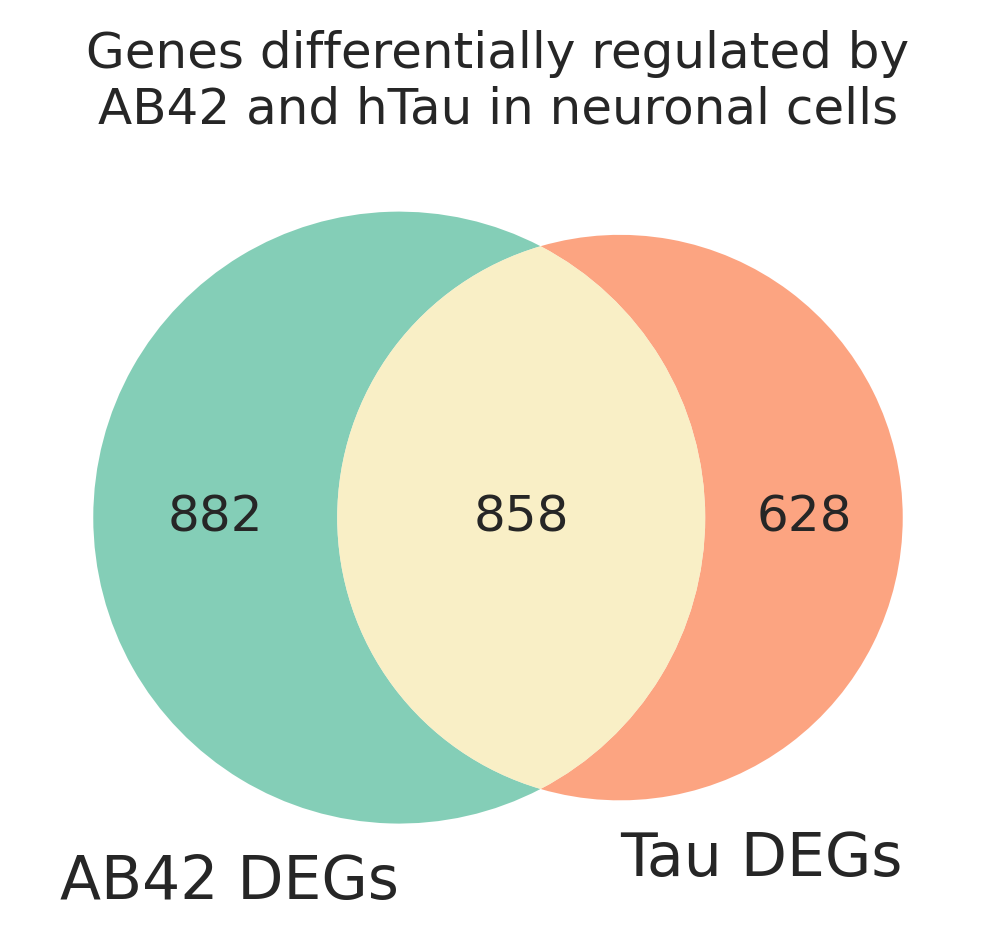

In [59]:
venn2( subsets= (882, 628, 858), set_colors=sns.color_palette("Set2")[:3], alpha=0.8, set_labels=('AB42 DEGs', 'Tau DEGs', ))
# venn2( subsets= (492, 931, 130), set_colors=['steelblue', 'orange'], alpha=0.8, set_labels=('markers in fly', 'markers in human'))
plt.title('Genes differentially regulated by\nAB42 and hTau in neuronal cells')
plt.savefig(f'{figureTauComPicFolder}/venn_panNeuron_degsAB42_degsTau.pdf')

## GOs enriched in the AB or Tau DEGs

### Load ontologies and associations

In [60]:
import goatools

In [61]:
goatools.__version__

'1.3.1'

In [62]:
!pwd

/data/tcl/Project/ADFCA


In [63]:
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

obodag = GODag("../../Resource/GO/go-basic.obo")
ogaf = GafReader("../../Resource/GO/FlyBase_gene_association_09082022.gaf") # FlyBase file

../../Resource/GO/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms
HMS:0:00:02.775563 121,359 annotations READ: ../../Resource/GO/FlyBase_gene_association_09082022.gaf 


In [64]:
ns2assc = ogaf.get_ns2assc()

### Load Background gene set

In [65]:
geneid2symbol_Df=pd.read_table('cellrangerSummary/features.tsv', header=None, index_col=0)
geneid2symbol_Df.head()

,1,2
0,,
FBgn0267594,CR45932,Gene Expression
FBgn0259849,Su(Ste):CR42418,Gene Expression
FBgn0085494,Mst77Y-16Psi,Gene Expression
FBgn0085506,CG40635,Gene Expression
FBgn0259870,Su(Ste):CR42439,Gene Expression


In [66]:
geneid2symbol_Df = geneid2symbol_Df[geneid2symbol_Df.iloc[:,0].isin(adata_head.var_names.to_list())]
geneid2symbol_Df

,1,2
0,,
FBgn0259849,Su(Ste):CR42418,Gene Expression
FBgn0085494,Mst77Y-16Psi,Gene Expression
FBgn0085506,CG40635,Gene Expression
FBgn0259870,Su(Ste):CR42439,Gene Expression
FBgn0259817,SteXh:CG42398,Gene Expression
...,...,...
FBgn0085753,28SrRNA-Psi:CR40596,Gene Expression
FBgn0267511,28SrRNA-Psi:CR45851,Gene Expression
FBgn0267505,pre-rRNA:CR45845,Gene Expression


In [67]:
geneid2symbol_D= dict(zip(geneid2symbol_Df.index.to_list(), geneid2symbol_Df[1].to_list()))

In [68]:
symbol2geneid_D= dict(zip(geneid2symbol_Df[1].to_list(), geneid2symbol_Df.index.to_list()))

### Initialize a GOEA object 

In [69]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        geneid2symbol_D, # List of fly protein-coding genes
        ns2assc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 59%  9,593 of 16,216 population items found in association

Load CC Ontology Enrichment Analysis ...
 57%  9,244 of 16,216 population items found in association

Load MF Ontology Enrichment Analysis ...
 53%  8,637 of 16,216 population items found in association


### Identify GOs

In [70]:
# AB42 GOs
id_L=[symbol2geneid_D[x] for x in degAB42_L]
goea_results_all = goeaobj.run_study(id_L)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

goeaobj.wr_tsv(f"{degGenoControlBroadNeuFolder}/GO_panNeuron_degAB42_symbols.tsv", goea_results_sig, itemid2name=geneid2symbol_D)
goeaobj.wr_tsv(f"{degGenoControlBroadNeuFolder}/GO_panNeuron_degAB42_geneids.tsv", goea_results_sig)


Runing BP Ontology Analysis: current study set of 1740 IDs.
 83%  1,436 of  1,740 study items found in association
100%  1,740 of  1,740 study items found in population(16216)
Calculating 5,151 uncorrected p-values using fisher_scipy_stats
   5,151 terms are associated with  9,593 of 16,216 population items
   2,684 terms are associated with  1,436 of  1,740 study items
  METHOD fdr_bh:
     289 GO terms found significant (< 0.05=alpha) (286 enriched +   3 purified): statsmodels fdr_bh
   1,034 study items associated with significant GO IDs (enriched)
      29 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 1740 IDs.
 81%  1,408 of  1,740 study items found in association
100%  1,740 of  1,740 study items found in population(16216)
Calculating 1,088 uncorrected p-values using fisher_scipy_stats
   1,088 terms are associated with  9,244 of 16,216 population items
     587 terms are associated with  1,408 of  1,740 study items


In [71]:
# Tau GOs
id_L=[symbol2geneid_D[x] for x in degTau_L]
goea_results_all = goeaobj.run_study(id_L)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

goeaobj.wr_tsv(f"{degGenoControlBroadNeuFolder}/GO_panNeuron_degTau_symbols.tsv", goea_results_sig, itemid2name=geneid2symbol_D)
goeaobj.wr_tsv(f"{degGenoControlBroadNeuFolder}/GO_panNeuron_degTau_geneids.tsv", goea_results_sig)


Runing BP Ontology Analysis: current study set of 1486 IDs.
 83%  1,238 of  1,486 study items found in association
100%  1,486 of  1,486 study items found in population(16216)
Calculating 5,151 uncorrected p-values using fisher_scipy_stats
   5,151 terms are associated with  9,593 of 16,216 population items
   2,541 terms are associated with  1,238 of  1,486 study items
  METHOD fdr_bh:
     339 GO terms found significant (< 0.05=alpha) (335 enriched +   4 purified): statsmodels fdr_bh
     964 study items associated with significant GO IDs (enriched)
      23 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 1486 IDs.
 81%  1,200 of  1,486 study items found in association
100%  1,486 of  1,486 study items found in population(16216)
Calculating 1,088 uncorrected p-values using fisher_scipy_stats
   1,088 terms are associated with  9,244 of 16,216 population items
     565 terms are associated with  1,200 of  1,486 study items


In [81]:
set(degAB42_L) & set(degTau_L)

{'14-3-3zeta',
 '5-HT1A',
 '5-HT2A',
 '7B2',
 'ABCA',
 'ABCD',
 'AGO1',
 'AGO2',
 'AGO3',
 'AP-1gamma',
 'ATPsynC',
 'ATPsynD',
 'ATPsynF',
 'ATPsynbeta',
 'ATPsyndelta',
 'Ac3',
 'AcCoAS',
 'Acsl',
 'Act5C',
 'Actbeta',
 'Adar',
 'Ae2',
 'Ald1',
 'Alg-2',
 'Alh',
 'Alk',
 'Arf79F',
 'Arr1',
 'Arr2',
 'Ars2',
 'Asator',
 'AstA-R1',
 'Atet',
 'Atf6',
 'Atg8a',
 'Atpalpha',
 'Atx2',
 'B52',
 'BI-1',
 'Bacc',
 'BicD',
 'Bx',
 'CASK',
 'CCT2',
 'CG10011',
 'CG10077',
 'CG10353',
 'CG10383',
 'CG10543',
 'CG10948',
 'CG11122',
 'CG11360',
 'CG11537',
 'CG11873',
 'CG11883',
 'CG12025',
 'CG12535',
 'CG12567',
 'CG12991',
 'CG13366',
 'CG13375',
 'CG13506',
 'CG13585',
 'CG13685',
 'CG13743',
 'CG13784',
 'CG13868',
 'CG13917',
 'CG13954',
 'CG14015',
 'CG14082',
 'CG14431',
 'CG14435',
 'CG14669',
 'CG14853',
 'CG14995',
 'CG15118',
 'CG15236',
 'CG15270',
 'CG15431',
 'CG15760',
 'CG15765',
 'CG15803',
 'CG15894',
 'CG16791',
 'CG1695',
 'CG16974',
 'CG1703',
 'CG17124',
 'CG17378',
 'CG17

In [82]:
# common GOs
overlap_L = list( set(degAB42_L) & set(degTau_L) )
id_L=[symbol2geneid_D[x] for x in overlap_L]
goea_results_all = goeaobj.run_study(id_L)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

goeaobj.wr_tsv(f"{degGenoControlBroadNeuFolder}/GO_panNeuron_degAB42Tau_symbols.tsv", goea_results_sig, itemid2name=geneid2symbol_D)
goeaobj.wr_tsv(f"{degGenoControlBroadNeuFolder}/GO_panNeuron_degAB42Tau_geneids.tsv", goea_results_sig)


Runing BP Ontology Analysis: current study set of 858 IDs.
 83%    710 of    858 study items found in association
100%    858 of    858 study items found in population(16216)
Calculating 5,151 uncorrected p-values using fisher_scipy_stats
   5,151 terms are associated with  9,593 of 16,216 population items
   1,887 terms are associated with    710 of    858 study items
  METHOD fdr_bh:
     175 GO terms found significant (< 0.05=alpha) (175 enriched +   0 purified): statsmodels fdr_bh
     508 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 858 IDs.
 80%    686 of    858 study items found in association
100%    858 of    858 study items found in population(16216)
Calculating 1,088 uncorrected p-values using fisher_scipy_stats
   1,088 terms are associated with  9,244 of 16,216 population items
     417 terms are associated with    686 of    858 study items
  

In [72]:
ab42GO_Df = pd.read_csv(f"{degGenoControlBroadNeuFolder}/GO_panNeuron_degAB42_symbols.tsv", sep='\t')
ab42GO_Df['group'] = 'AB42'
ab42GO_Df['-log10FDR'] = -np.log10(ab42GO_Df.p_fdr_bh)
ab42GO_Df = ab42GO_Df[ab42GO_Df.enrichment == 'e']
ab42GO_Df_top10 =ab42GO_Df.iloc[:10,:]

tauGO_Df = pd.read_csv(f"{degGenoControlBroadNeuFolder}/GO_panNeuron_degTau_symbols.tsv", sep='\t')
tauGO_Df['group'] = 'hTau'
tauGO_Df['-log10FDR'] = -np.log10(tauGO_Df.p_fdr_bh)
tauGO_Df = tauGO_Df[tauGO_Df.enrichment == 'e']
tauGO_Df_top10 =tauGO_Df.iloc[:10,:]

ab42GO_Df_top10

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items,group,-log10FDR
0,GO:0007411,BP,e,axon guidance,65/1740,165/16216,4.794271e-22,8,65,2.469529e-18,"AP-1sigma, Acsl, Alk, CadN, Cdc42, DAAM, DIP2,...",AB42,17.607386
1,GO:0007268,BP,e,chemical synaptic transmission,41/1740,93/16216,1.820802e-16,7,41,4.689476e-13,"5-HT1A, 5-HT2A, 5-HT7, Ace, Acsl, Atpalpha, Ca...",AB42,12.328876
2,GO:0006468,BP,e,protein phosphorylation,57/1740,193/16216,4.597245e-13,6,57,7.893469e-10,"Akt1, Alk, CASK, CG17528, CG17698, CG3008, CG3...",AB42,9.102732
3,GO:0048813,BP,e,dendrite morphogenesis,39/1740,110/16216,4.531579e-12,9,39,5.835541e-09,"CG9705, Cdc42, Dlic, EcR, Lis-1, Mical, Nrg, R...",AB42,8.233919
4,GO:0007616,BP,e,long-term memory,30/1740,74/16216,2.718661e-11,7,30,2.800764e-08,"ATP6AP2, Appl, Atx2, CASK, CG4612, CaMKII, Cre...",AB42,7.552723
5,GO:0007476,BP,e,imaginal disc-derived wing morphogenesis,41/1740,128/16216,5.294884e-11,5,41,4.545658e-08,"Arf79F, Bx, Dad, Drak, EcR, Gclc, Mad, Pcyt1, ...",AB42,7.342403
6,GO:0007029,BP,e,endoplasmic reticulum organization,14/1740,19/16216,1.763810e-10,5,14,1.297912e-07,"Marf, ReepA, ReepB, Rtnl1, Sar1, Sec16, Sec23,...",AB42,6.886755
7,GO:0034976,BP,e,response to endoplasmic reticulum stress,19/1740,35/16216,2.592763e-10,4,19,1.669415e-07,"CG11873, CG9003, CG9005, CaBP1, Calx, Cbs, Der...",AB42,6.777436
8,GO:0035556,BP,e,intracellular signal transduction,34/1740,100/16216,3.861593e-10,5,34,2.210119e-07,"Ac3, Ac76E, Akt1, CG10916, CG17528, CG17698, C...",AB42,6.655584
9,GO:0007015,BP,e,actin filament organization,26/1740,65/16216,8.071935e-10,5,26,4.157854e-07,"Mical, Msp300, Myo81F, Myo95E, Pak3, Pka-R1, R...",AB42,6.381131


In [73]:
ab42GO_Df.head(20)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items,group,-log10FDR
0,GO:0007411,BP,e,axon guidance,65/1740,165/16216,4.794271e-22,8,65,2.469529e-18,"AP-1sigma, Acsl, Alk, CadN, Cdc42, DAAM, DIP2,...",AB42,17.607386
1,GO:0007268,BP,e,chemical synaptic transmission,41/1740,93/16216,1.820802e-16,7,41,4.689476e-13,"5-HT1A, 5-HT2A, 5-HT7, Ace, Acsl, Atpalpha, Ca...",AB42,12.328876
2,GO:0006468,BP,e,protein phosphorylation,57/1740,193/16216,4.597245e-13,6,57,7.893469e-10,"Akt1, Alk, CASK, CG17528, CG17698, CG3008, CG3...",AB42,9.102732
3,GO:0048813,BP,e,dendrite morphogenesis,39/1740,110/16216,4.531579e-12,9,39,5.835541e-09,"CG9705, Cdc42, Dlic, EcR, Lis-1, Mical, Nrg, R...",AB42,8.233919
4,GO:0007616,BP,e,long-term memory,30/1740,74/16216,2.718661e-11,7,30,2.800764e-08,"ATP6AP2, Appl, Atx2, CASK, CG4612, CaMKII, Cre...",AB42,7.552723
5,GO:0007476,BP,e,imaginal disc-derived wing morphogenesis,41/1740,128/16216,5.294884e-11,5,41,4.545658e-08,"Arf79F, Bx, Dad, Drak, EcR, Gclc, Mad, Pcyt1, ...",AB42,7.342403
6,GO:0007029,BP,e,endoplasmic reticulum organization,14/1740,19/16216,1.763810e-10,5,14,1.297912e-07,"Marf, ReepA, ReepB, Rtnl1, Sar1, Sec16, Sec23,...",AB42,6.886755
7,GO:0034976,BP,e,response to endoplasmic reticulum stress,19/1740,35/16216,2.592763e-10,4,19,1.669415e-07,"CG11873, CG9003, CG9005, CaBP1, Calx, Cbs, Der...",AB42,6.777436
8,GO:0035556,BP,e,intracellular signal transduction,34/1740,100/16216,3.861593e-10,5,34,2.210119e-07,"Ac3, Ac76E, Akt1, CG10916, CG17528, CG17698, C...",AB42,6.655584
9,GO:0007015,BP,e,actin filament organization,26/1740,65/16216,8.071935e-10,5,26,4.157854e-07,"Mical, Msp300, Myo81F, Myo95E, Pak3, Pka-R1, R...",AB42,6.381131


In [74]:
tauGO_Df.head(50)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items,group,-log10FDR
0,GO:0007411,BP,e,axon guidance,60/1486,165/16216,7.569526e-22,8,60,3.899063e-18,"14-3-3epsilon, Abl, Acsl, Alk, Bsg, CadN, Cdk5...",hTau,17.409040
1,GO:0007268,BP,e,chemical synaptic transmission,37/1486,93/16216,1.873929e-15,7,37,4.826303e-12,"5-HT1A, 5-HT2A, Abl, Acsl, Atpalpha, CaMKII, E...",hTau,11.316385
2,GO:0006357,BP,e,regulation of transcription by RNA polymerase II,119/1486,635/16216,1.934331e-14,10,119,3.321246e-11,"Alh, Antp, Atf6, Axud1, Blimp-1, BtbVII, CG105...",hTau,10.478699
3,GO:0045944,BP,e,positive regulation of transcription by RNA po...,73/1486,315/16216,5.901689e-14,11,73,7.599900e-11,"Antp, Axud1, Bx, CG10543, CG12769, CG2962, CG8...",hTau,10.119192
4,GO:0001745,BP,e,compound eye morphogenesis,34/1486,89/16216,1.065127e-13,6,34,1.097294e-10,"Arf51F, Arf79F, Efa6, Hrb98DE, Mad, Mitf, Nhe2...",hTau,9.959677
5,GO:0006468,BP,e,protein phosphorylation,52/1486,193/16216,5.465844e-13,6,52,4.041915e-10,"Alk, Atg1, CASK, CG17698, CG34357, CG4629, CG7...",hTau,9.393413
6,GO:0045475,BP,e,locomotor rhythm,27/1486,61/16216,5.492798e-13,5,27,4.041915e-10,"Ac3, Adar, Atx2, Bx, CkIIalpha, CkIIbeta, Clk,...",hTau,9.393413
7,GO:0098609,BP,e,cell-cell adhesion,23/1486,45/16216,6.464620e-13,3,23,4.162407e-10,"Bsg, CG17716, CG45049, CG45263, Cad99C, CadN, ...",hTau,9.380655
8,GO:0035556,BP,e,intracellular signal transduction,35/1486,100/16216,9.543126e-13,5,35,5.461849e-10,"Ac3, CG17698, CG31140, CG32944, CG34384, CG389...",hTau,9.262660
9,GO:0007165,BP,e,signal transduction,44/1486,149/16216,1.093177e-12,4,44,5.630957e-10,"14-3-3epsilon, 14-3-3zeta, Ank, Asator, CG1337...",hTau,9.249418


In [75]:
ab42GO_Df_top10 = ab42GO_Df_top10.loc[:, ['group', 'name', '-log10FDR', ]]
tauGO_Df_top10 = tauGO_Df_top10.loc[:, ['group', 'name', '-log10FDR', ]]

ab42GO_Df_top10

,group,name,-log10FDR
0,AB42,axon guidance,17.607386
1,AB42,chemical synaptic transmission,12.328876
2,AB42,protein phosphorylation,9.102732
3,AB42,dendrite morphogenesis,8.233919
4,AB42,long-term memory,7.552723
5,AB42,imaginal disc-derived wing morphogenesis,7.342403
6,AB42,endoplasmic reticulum organization,6.886755
7,AB42,response to endoplasmic reticulum stress,6.777436
8,AB42,intracellular signal transduction,6.655584
9,AB42,actin filament organization,6.381131


In [76]:
overlapGO_L = list(set(ab42GO_Df_top10.name) & set(tauGO_Df_top10.name))
overlapGO_L

['axon guidance',
 'intracellular signal transduction',
 'protein phosphorylation',
 'chemical synaptic transmission']

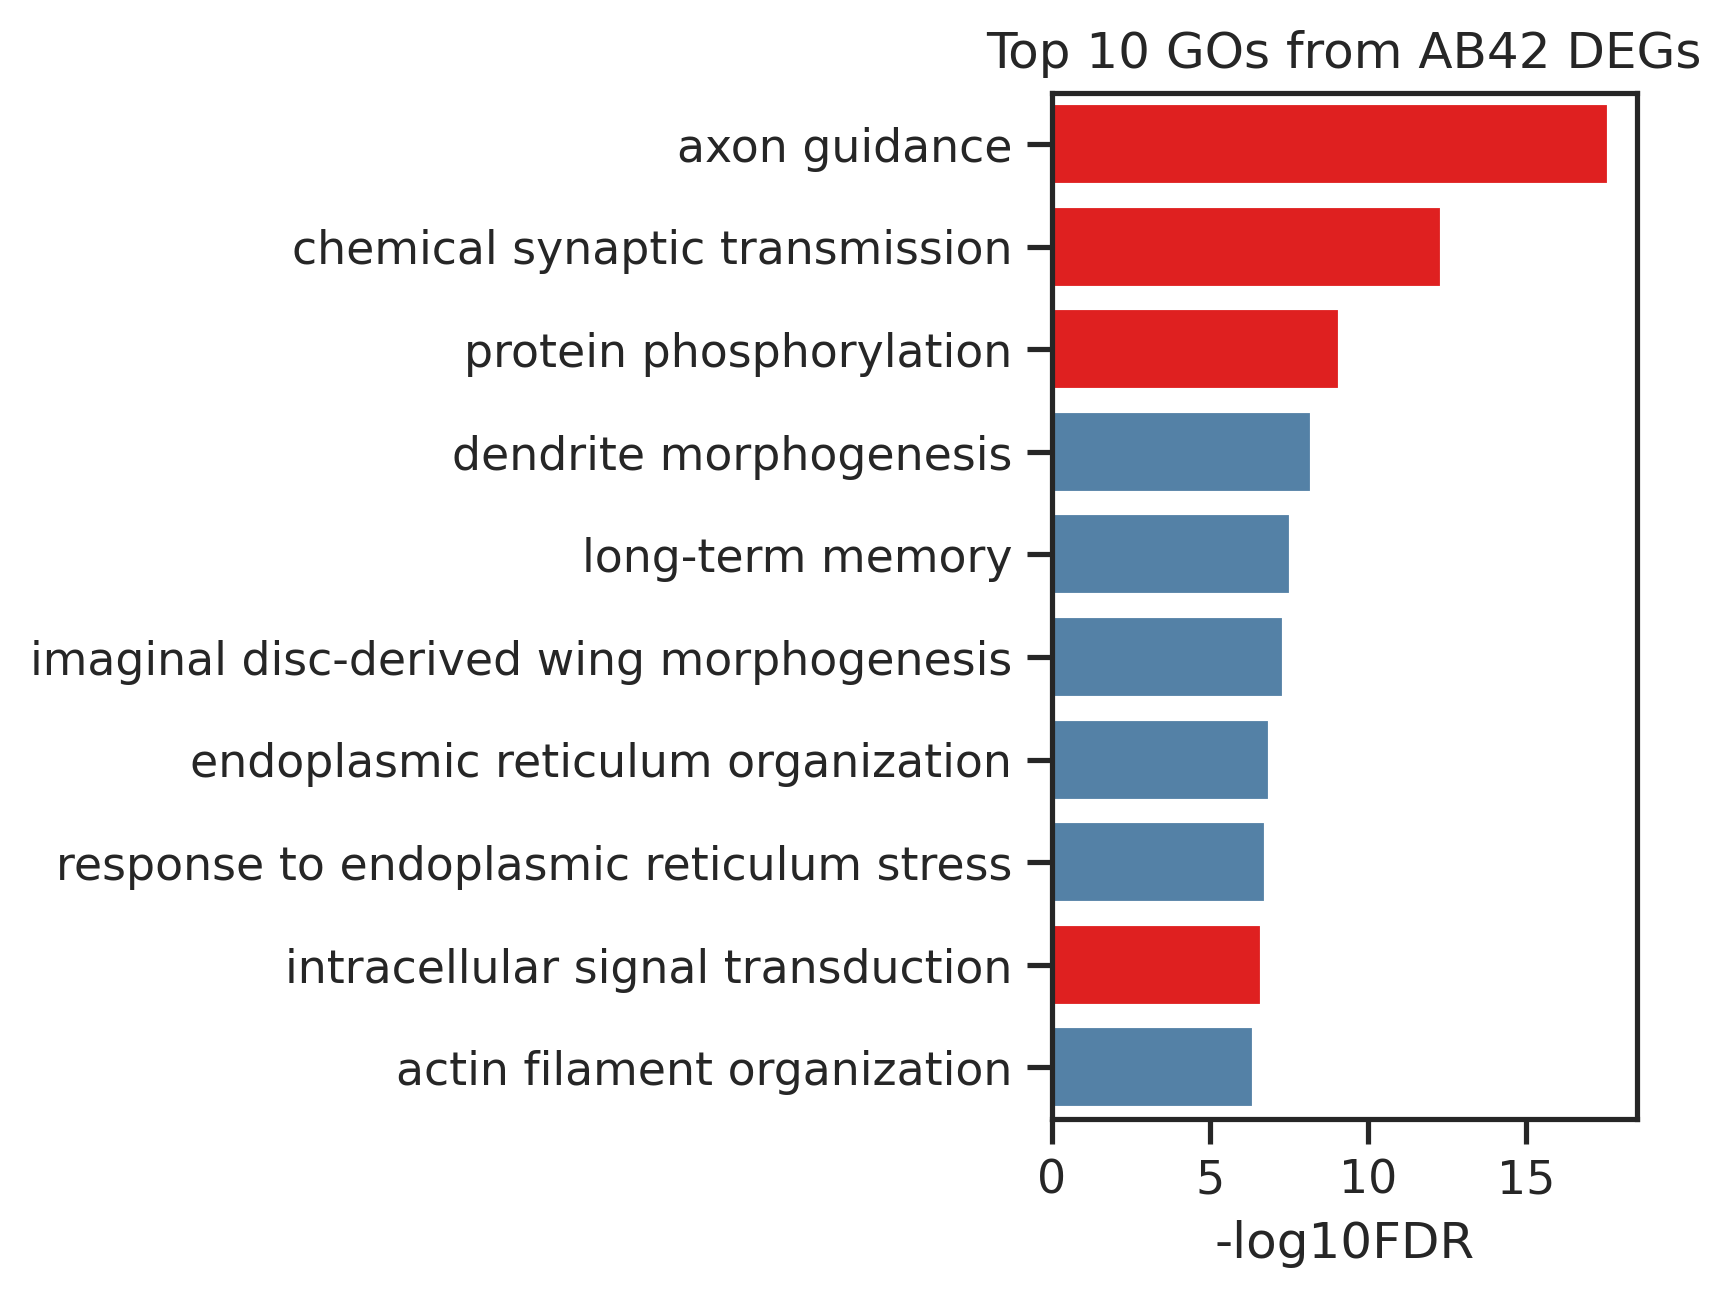

In [78]:
fig, ax = plt.subplots(figsize=(2.5, 4.5))
sns.barplot(data=ab42GO_Df_top10, x = '-log10FDR', y = 'name', ax=ax, width=0.8, color='steelblue', 
            palette=['red' if name in overlapGO_L else 'steelblue' for name in ab42GO_Df_top10.name])
plt.ylabel('')
plt.title('Top 10 GOs from AB42 DEGs')
plt.savefig(f'{figureTauComPicFolder}/barplot_GO_panNeuron_ab42GO_Df_top10.pdf', bbox_inches='tight')

plt.show()

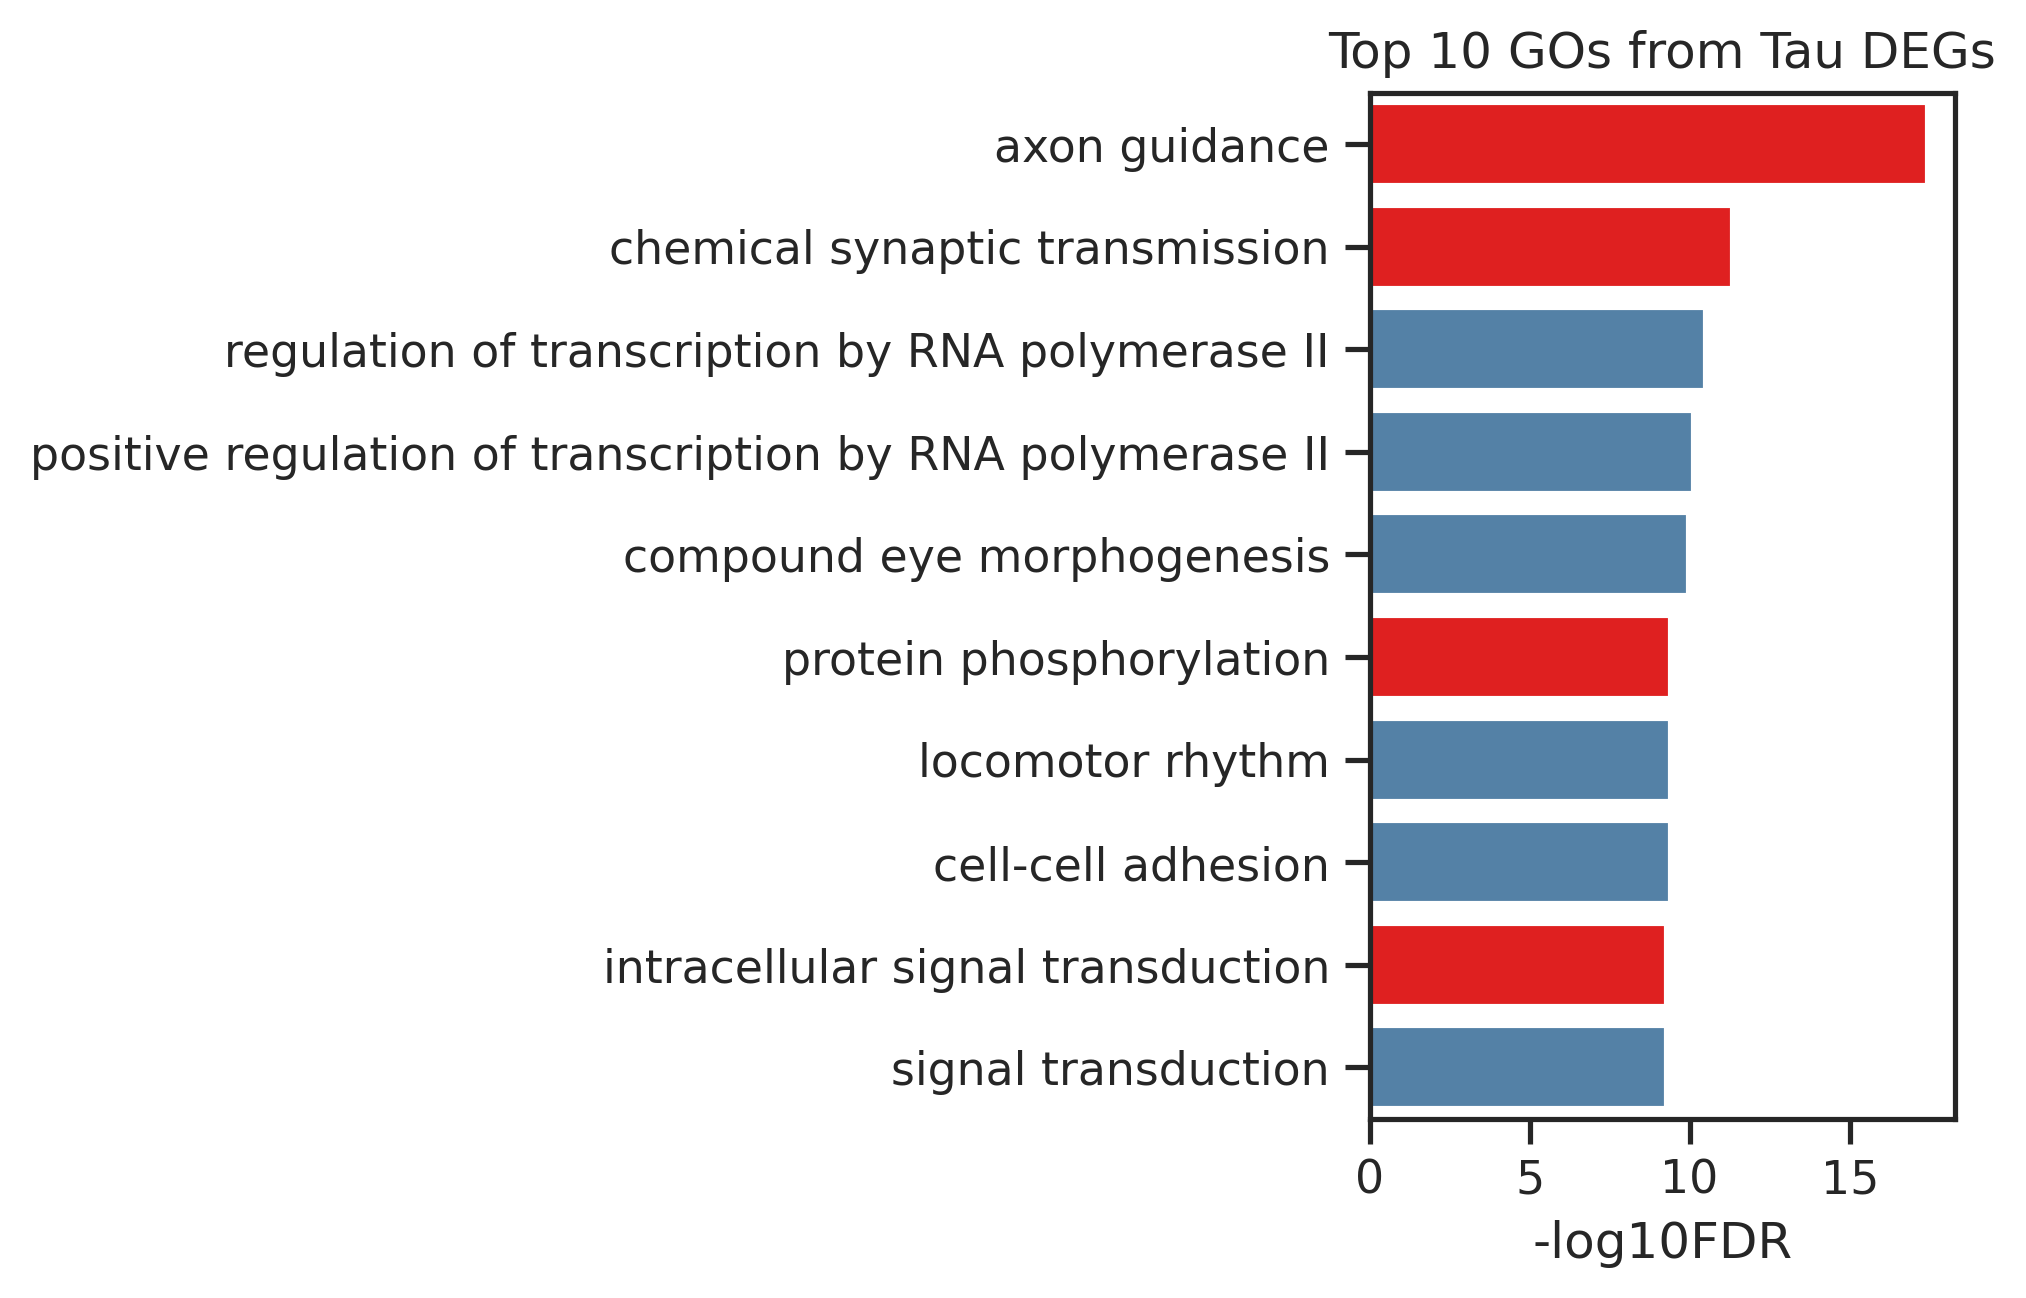

In [79]:
fig, ax = plt.subplots(figsize=(2.5, 4.5))
sns.barplot(data=tauGO_Df_top10, x = '-log10FDR', y = 'name', ax=ax, width=0.8, color='steelblue', 
            palette=['red' if name in overlapGO_L else 'steelblue' for name in tauGO_Df_top10.name])
plt.ylabel('')
plt.title('Top 10 GOs from Tau DEGs')
plt.savefig(f'{figureTauComPicFolder}/barplot_GO_panNeuron_tauGO_Df_top10.pdf', bbox_inches='tight')

plt.show()

# SupFig: Overlaps of AB42 and Tau DEGs

## Load files

In [23]:
# adata_head = sc.read('/data/tcl/Project/ADFCA/adataProcess/v0.6/adfca_head_v0.6_woHarmony_raw.h5ad')
# adata_body = sc.read('/data/tcl/Project/ADFCA/adataProcess/v0.6/adfca_body_v0.6_woHarmony_raw.h5ad')

In [22]:
adata_head = sc.read('/data/tcl/Project/ADFCA/adataProcess/v1.0/adata_adfca_head_v1.0.h5ad')
adata_body = sc.read('/data/tcl/Project/ADFCA/adataProcess/v1.0/adata_adfca_body_v1.0.h5ad')

/data/tcl/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/data/tcl/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [23]:
adata_headBody = adata_head.concatenate(adata_body, join='outer')
adata_headBody

<ipython-input-23-d569f6e12017>:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_headBody = adata_head.concatenate(adata_body, join='outer')


AnnData object with n_obs × n_vars = 624458 × 16219
    obs: 'sample', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'sex', 'tissue', 'age', 'genotype', 'sex_age', 'genoAge', 'genoSex', 'genoAgeSex', 'adfca_annotation', 'adfca_annotation_broad', 'adfca_annotation_group', 'adfca_annotation_subcluster', 'batch'
    var: 'gene_ids', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'latent_gene_encoding'
    layers: 'logNormalize_exp', 'umi_counts'

In [24]:
# neuronCellType_L
broadNeuron_L = [broadtype for broadtype in pd.Categorical(adata_headBody.obs.adfca_annotation_broad).categories if 'neuron' in broadtype] # 
broadNeuron_L

['CNS neuron', 'PNS neuron', 'sensory neuron']

In [25]:
annotation_Df = pd.read_csv(f'/data/tcl/Project/ADFCA/adataProcess/v0.6/adfca_annotation_detailed_and_broad_detailed_subcluster.csv')
annotation_Df

,adfca_annotation_broad,adfca_annotation_group,adfca_annotation,adfca_annotation_subcluster,cellN
0,CNS neuron,ABeta42-specific cluster,ABeta42-specific cluster,ABeta42-specific cluster,3765
1,CNS neuron,CNS neuron ungrouped,neuron 1,neuron 1,1118
2,CNS neuron,CNS neuron ungrouped,neuron 10,neuron 10,589
3,CNS neuron,CNS neuron ungrouped,neuron 11,neuron 11,624
4,CNS neuron,CNS neuron ungrouped,neuron 12,neuron 12,417
...,...,...,...,...,...
215,sensory neuron,sensory neuron,scolopidial neuron,scolopidial neuron,659
216,tracheal cell,tracheal cell,adult tracheal cell_body,adult tracheal cell_body,7900
217,tracheal cell,tracheal cell,adult tracheal cell_head,adult tracheal cell_head,6560
218,unannotated,unannotated,antimicrobial peptide-producing cell,antimicrobial peptide-producing cell,507


In [26]:
neuronCellType_L = annotation_Df[annotation_Df.adfca_annotation_broad.isin(broadNeuron_L)].adfca_annotation.to_list()
nonNeuronCellType_L = annotation_Df[~annotation_Df.adfca_annotation_broad.isin(broadNeuron_L)].adfca_annotation.to_list()
# neuronCellType_L

In [27]:
annot2Broad_D = dict(zip(annotation_Df.adfca_annotation, annotation_Df.adfca_annotation_broad))
# annot2Broad_D

## Cell type specificity of DEG

### Load DEG file

In [28]:
degAllE05Gene_Df = pd.read_csv(f'{figure3Folder}/degSummary/degLong_Df_genotype_compareToControl_cellN700.csv', index_col=0)

In [29]:
degAllE05Gene_Df

,names,pvals,pvals_adj,logfoldchanges,annotation,group
0,Pde9,8.831894e-52,1.432445e-47,-1.246592,16-cell germline cyst in germarium region 2a a...,AB42
1,mt:lrRNA,2.705211e-32,2.193791e-28,3.499738,16-cell germline cyst in germarium region 2a a...,AB42
2,pre-rRNA:CR45845,6.289391e-26,3.400254e-22,0.674733,16-cell germline cyst in germarium region 2a a...,AB42
3,pAbp,4.220895e-26,6.845869e-22,-1.621699,16-cell germline cyst in germarium region 2a a...,hTau
4,Dscam4,6.435551e-25,2.609455e-21,6.977312,16-cell germline cyst in germarium region 2a a...,AB42
...,...,...,...,...,...,...
43616,mAChR-A,6.574077e-05,3.046427e-02,1.330468,transmedullary neuron Tm9,AB42
43617,CG32982,7.315896e-05,3.296014e-02,-0.725272,transmedullary neuron Tm9,AB42
43618,CadN2,1.217911e-05,3.950660e-02,1.349271,transmedullary neuron Tm9,hTau
43619,Fife,1.009878e-04,4.426814e-02,-1.287957,transmedullary neuron Tm9,AB42


In [30]:
degAllE05Gene_Df[(degAllE05Gene_Df.pvals_adj <= 0.05) & (degAllE05Gene_Df.group.isin(['AB42']))].to_csv(f'{figure3Folder}/degSummary/degAllE05Gene_Df_AB42.csv', index=False)
degAllE05Gene_Df[(degAllE05Gene_Df.pvals_adj <= 0.05) & (degAllE05Gene_Df.group.isin(['hTau']))].to_csv(f'{figure3Folder}/degSummary/degAllE05Gene_Df_hTau.csv', index=False)

In [31]:
degAB42_Df = pd.read_csv(f'{figure3Folder}/degSummary/degAllE05Gene_Df_AB42.csv')
degTau_Df = pd.read_csv(f'{figure3Folder}/degSummary/degAllE05Gene_Df_hTau.csv')
# degAB42_Df

In [32]:
degAB42_Df

,names,pvals,pvals_adj,logfoldchanges,annotation,group
0,Pde9,8.831894e-52,1.432445e-47,-1.246592,16-cell germline cyst in germarium region 2a a...,AB42
1,mt:lrRNA,2.705211e-32,2.193791e-28,3.499738,16-cell germline cyst in germarium region 2a a...,AB42
2,pre-rRNA:CR45845,6.289391e-26,3.400254e-22,0.674733,16-cell germline cyst in germarium region 2a a...,AB42
3,Dscam4,6.435551e-25,2.609455e-21,6.977312,16-cell germline cyst in germarium region 2a a...,AB42
4,ABeta42,5.338449e-22,1.731686e-18,28.988680,16-cell germline cyst in germarium region 2a a...,AB42
...,...,...,...,...,...,...
19396,Xbp1,6.343045e-05,3.025819e-02,5.114261,transmedullary neuron Tm9,AB42
19397,mAChR-A,6.574077e-05,3.046427e-02,1.330468,transmedullary neuron Tm9,AB42
19398,CG32982,7.315896e-05,3.296014e-02,-0.725272,transmedullary neuron Tm9,AB42
19399,Fife,1.009878e-04,4.426814e-02,-1.287957,transmedullary neuron Tm9,AB42


In [33]:
degAllE05Gene_Df_noAbeta = degAllE05Gene_Df[~degAllE05Gene_Df.names.isin(['ABeta42', 'hTau0N4Rfull'])]
degNeuron_Df_noAbeta = degAllE05Gene_Df_noAbeta[degAllE05Gene_Df_noAbeta.annotation.isin(neuronCellType_L)]
degNonNeuron_Df_noAbeta = degAllE05Gene_Df_noAbeta[degAllE05Gene_Df_noAbeta.annotation.isin(nonNeuronCellType_L)]
degNeuron_Df_noAbeta

,names,pvals,pvals_adj,logfoldchanges,annotation,group
313,Hsc70-3,1.367033e-80,2.217190e-76,6.876618,ABeta42-specific cluster,AB42
314,hzg,8.662320e-78,7.024709e-74,6.042689,ABeta42-specific cluster,AB42
315,Calr,5.075723e-39,2.744105e-35,5.846174,ABeta42-specific cluster,AB42
317,Gp93,5.557064e-28,1.802600e-24,4.749421,ABeta42-specific cluster,AB42
318,Lk6,2.344799e-28,3.803030e-24,1.899922,ABeta42-specific cluster,hTau
...,...,...,...,...,...,...
43616,mAChR-A,6.574077e-05,3.046427e-02,1.330468,transmedullary neuron Tm9,AB42
43617,CG32982,7.315896e-05,3.296014e-02,-0.725272,transmedullary neuron Tm9,AB42
43618,CadN2,1.217911e-05,3.950660e-02,1.349271,transmedullary neuron Tm9,hTau
43619,Fife,1.009878e-04,4.426814e-02,-1.287957,transmedullary neuron Tm9,AB42


### Neuronal Cells: compare DEG frequency between AB42 and hTau

In [34]:
degNeuron_L = degNeuron_Df_noAbeta.names.value_counts().index.to_list()
degN_neuron_Df = pd.DataFrame(columns=['gene', 'AB42', 'hTau'])

n=0
for n, gene in enumerate(degNeuron_L[:]):
    gene_Df = degNeuron_Df_noAbeta[degNeuron_Df_noAbeta.names == gene]
    
    abetaDegN = gene_Df.group.isin(['AB42']).sum()
    
    tauDegN = gene_Df.group.isin(['hTau']).sum()
    # print(gene, abetaDegN_10, tauDegN_20, abetaDegN_20, tauDegN_30)
    
    degN_neuron_Df.loc[len(degN_neuron_Df)] = [gene, abetaDegN, tauDegN]

degN_neuron_Df

,gene,AB42,hTau
0,lncRNA:noe,48,24
1,dpr21,51,4
2,lncRNA:Hsromega,12,38
3,hzg,44,1
4,Parp,2,38
...,...,...,...
2077,fwd,0,1
2078,wat,0,1
2079,CG12290,1,0
2080,beat-Ib,1,0


In [35]:
degN_neuron_Df['sum'] = degN_neuron_Df.AB42 + degN_neuron_Df.hTau
degN_neuron_Df.sort_values(by='sum', inplace=True, ascending=False)

In [36]:
degN_neuron_Df.to_csv(f'{figure3Folder}/degN_neuron_Df.csv', index=False)

## Overlapeed DEGs

In [37]:
degN_neuron_Df = pd.read_csv(f'{figure3Folder}/degN_neuron_Df.csv')

In [38]:
degN_neuron_Df

,gene,AB42,hTau,sum
0,lncRNA:noe,48,24,72
1,dpr21,51,4,55
2,lncRNA:Hsromega,12,38,50
3,hzg,44,1,45
4,Parp,2,38,40
...,...,...,...,...
2077,Wnk,0,1,1
2078,CG4660,0,1,1
2079,Rdh,0,1,1
2080,Tusp,1,0,1


In [39]:
degAB_Df = degN_neuron_Df[ (degN_neuron_Df.AB42 != 0) ]
degTau_Df = degN_neuron_Df[ (degN_neuron_Df.hTau != 0) ]

In [40]:
degAB_Df

,gene,AB42,hTau,sum
0,lncRNA:noe,48,24,72
1,dpr21,51,4,55
2,lncRNA:Hsromega,12,38,50
3,hzg,44,1,45
4,Parp,2,38,40
...,...,...,...,...
2073,NAAT1,1,0,1
2075,lncRNA:CR44831,1,0,1
2076,CG13737,1,0,1
2080,Tusp,1,0,1


In [41]:
from matplotlib_venn import venn2

In [42]:
sns.color_palette("Set2")[:3]

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549)]

In [43]:
### overlapped DEGs
len(set(degTau_Df.gene) & set(degAB_Df.gene))

943

In [44]:
print('AB42-specific DEG#: ', len(degAB_Df.gene) - len(set(degTau_Df.gene) & set(degAB_Df.gene)))
print('Tau-specific DEG#: ', len(degTau_Df.gene) - len(set(degTau_Df.gene) & set(degAB_Df.gene)))

AB42-specific DEG#:  646
Tau-specific DEG#:  493


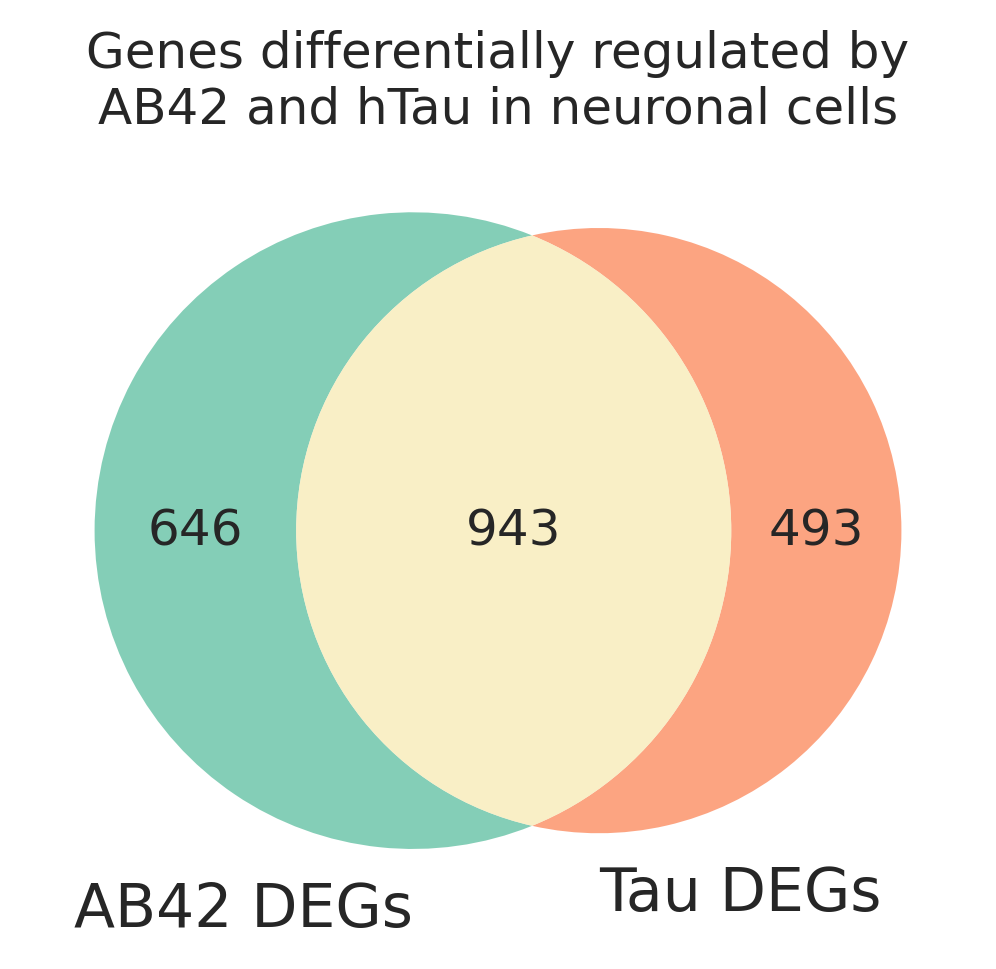

In [48]:
venn2( subsets= (646, 493, 943), set_colors=sns.color_palette("Set2")[:3], alpha=0.8, set_labels=('AB42 DEGs', 'Tau DEGs', ))
# venn2( subsets= (492, 931, 130), set_colors=['steelblue', 'orange'], alpha=0.8, set_labels=('markers in fly', 'markers in human'))
plt.title('Genes differentially regulated by\nAB42 and hTau in neuronal cells')
plt.savefig(f'{figure3PicFolder}/venn_degsAB42_degsTau.pdf')

## GOs enriched in the AB or Tau DEGs

### Load ontologies and associations

In [49]:
import goatools

In [50]:
goatools.__version__

'1.3.1'

In [51]:
!pwd

/data/tcl/Project/ADFCA


In [52]:
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

obodag = GODag("../../Resource/GO/go-basic.obo")
ogaf = GafReader("../../Resource/GO/FlyBase_gene_association_09082022.gaf") # FlyBase file

../../Resource/GO/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms
HMS:0:00:02.376689 121,359 annotations READ: ../../Resource/GO/FlyBase_gene_association_09082022.gaf 


In [53]:
ns2assc = ogaf.get_ns2assc()

### Load Background gene set

In [54]:
geneid2symbol_Df=pd.read_table('cellrangerSummary/features.tsv', header=None, index_col=0)
geneid2symbol_Df.head()

,1,2
0,,
FBgn0267594,CR45932,Gene Expression
FBgn0259849,Su(Ste):CR42418,Gene Expression
FBgn0085494,Mst77Y-16Psi,Gene Expression
FBgn0085506,CG40635,Gene Expression
FBgn0259870,Su(Ste):CR42439,Gene Expression


In [55]:
geneid2symbol_Df = geneid2symbol_Df[geneid2symbol_Df.iloc[:,0].isin(adata_head.var_names.to_list())]
geneid2symbol_Df

,1,2
0,,
FBgn0259849,Su(Ste):CR42418,Gene Expression
FBgn0085494,Mst77Y-16Psi,Gene Expression
FBgn0085506,CG40635,Gene Expression
FBgn0259870,Su(Ste):CR42439,Gene Expression
FBgn0259817,SteXh:CG42398,Gene Expression
...,...,...
FBgn0085753,28SrRNA-Psi:CR40596,Gene Expression
FBgn0267511,28SrRNA-Psi:CR45851,Gene Expression
FBgn0267505,pre-rRNA:CR45845,Gene Expression


In [56]:
geneid2symbol_D= dict(zip(geneid2symbol_Df.index.to_list(), geneid2symbol_Df[1].to_list()))

In [57]:
symbol2geneid_D= dict(zip(geneid2symbol_Df[1].to_list(), geneid2symbol_Df.index.to_list()))

### Initialize a GOEA object 

In [58]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        geneid2symbol_D, # List of fly protein-coding genes
        ns2assc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 59%  9,593 of 16,216 population items found in association

Load CC Ontology Enrichment Analysis ...
 57%  9,244 of 16,216 population items found in association

Load MF Ontology Enrichment Analysis ...
 53%  8,637 of 16,216 population items found in association


### Identify GOs

In [59]:
# AB42 GOs
id_L=[symbol2geneid_D[x] for x in degAB_Df.gene.to_list()]
goea_results_all = goeaobj.run_study(id_L)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

goeaobj.wr_tsv(f"{goAB42TauNameFolder}/degAB42_symbols.tsv", goea_results_sig, itemid2name=geneid2symbol_D)
goeaobj.wr_tsv(f"{goAB42TauIdFolder}/degAB42_geneids.tsv", goea_results_sig)


Runing BP Ontology Analysis: current study set of 1589 IDs.
 83%  1,312 of  1,589 study items found in association
100%  1,589 of  1,589 study items found in population(16216)
Calculating 5,151 uncorrected p-values using fisher_scipy_stats
   5,151 terms are associated with  9,593 of 16,216 population items
   2,604 terms are associated with  1,312 of  1,589 study items
  METHOD fdr_bh:
     306 GO terms found significant (< 0.05=alpha) (304 enriched +   2 purified): statsmodels fdr_bh
     959 study items associated with significant GO IDs (enriched)
      28 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 1589 IDs.
 80%  1,278 of  1,589 study items found in association
100%  1,589 of  1,589 study items found in population(16216)
Calculating 1,088 uncorrected p-values using fisher_scipy_stats
   1,088 terms are associated with  9,244 of 16,216 population items
     531 terms are associated with  1,278 of  1,589 study items


In [60]:
# Tau GOs
id_L=[symbol2geneid_D[x] for x in degTau_Df.gene.to_list()]
goea_results_all = goeaobj.run_study(id_L)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

goeaobj.wr_tsv(f"{goAB42TauNameFolder}/degTau_symbols.tsv", goea_results_sig, itemid2name=geneid2symbol_D)
goeaobj.wr_tsv(f"{goAB42TauIdFolder}/degTau_geneids.tsv", goea_results_sig)


Runing BP Ontology Analysis: current study set of 1436 IDs.
 83%  1,190 of  1,436 study items found in association
100%  1,436 of  1,436 study items found in population(16216)
Calculating 5,151 uncorrected p-values using fisher_scipy_stats
   5,151 terms are associated with  9,593 of 16,216 population items
   2,449 terms are associated with  1,190 of  1,436 study items
  METHOD fdr_bh:
     332 GO terms found significant (< 0.05=alpha) (329 enriched +   3 purified): statsmodels fdr_bh
     878 study items associated with significant GO IDs (enriched)
      22 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 1436 IDs.
 80%  1,152 of  1,436 study items found in association
100%  1,436 of  1,436 study items found in population(16216)
Calculating 1,088 uncorrected p-values using fisher_scipy_stats
   1,088 terms are associated with  9,244 of 16,216 population items
     510 terms are associated with  1,152 of  1,436 study items


In [61]:
ab42GO_Df = pd.read_csv(f"{goAB42TauNameFolder}/degAB42_symbols.tsv", sep='\t')
ab42GO_Df['group'] = 'AB42'
ab42GO_Df['-log10FDR'] = -np.log10(ab42GO_Df.p_fdr_bh)
ab42GO_Df = ab42GO_Df[ab42GO_Df.enrichment == 'e']
ab42GO_Df_top10 =ab42GO_Df.iloc[:10,:]

tauGO_Df = pd.read_csv(f"{goAB42TauNameFolder}/degTau_symbols.tsv", sep='\t')
tauGO_Df['group'] = 'hTau'
tauGO_Df['-log10FDR'] = -np.log10(tauGO_Df.p_fdr_bh)
tauGO_Df = tauGO_Df[tauGO_Df.enrichment == 'e']
tauGO_Df_top10 =tauGO_Df.iloc[:10,:]

ab42GO_Df_top10

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items,group,-log10FDR
0,GO:0007268,BP,e,chemical synaptic transmission,43/1589,93/16216,1.161786e-19,7,43,5.984359e-16,"5-HT1A, 5-HT2A, 5-HT2B, Ace, Acsl, Atpalpha, C...",AB42,15.222982
1,GO:0007476,BP,e,imaginal disc-derived wing morphogenesis,49/1589,128/16216,5.764382e-18,5,49,1.484617e-14,"Arf79F, Bx, CG30069, Cbl, Dad, Dl, EcR, Egfr, ...",AB42,13.828386
2,GO:0007411,BP,e,axon guidance,56/1589,165/16216,1.609849e-17,8,56,2.764110e-14,"AP-1sigma, Acsl, Alk, CG44153, CadN, Cdc42, Ds...",AB42,13.558445
3,GO:0007298,BP,e,border follicle cell migration,38/1589,94/16216,3.732104e-15,7,38,4.806017e-12,"Crk, Diap1, Dl, EcR, Egfr, Lis-1, Mrtf, Ptpmeg...",AB42,11.318215
4,GO:0048813,BP,e,dendrite morphogenesis,40/1589,110/16216,4.822571e-14,9,40,4.968213e-11,"BuGZ, Cdc42, Dlic, EcR, Lis-1, Nrg, Rab5, Rfx,...",AB42,10.303800
5,GO:0007616,BP,e,long-term memory,30/1589,74/16216,2.700469e-12,7,30,2.318352e-09,"ATP6AP2, Appl, Atx2, CaMKII, CrebB, Ddc, EcR, ...",AB42,8.634821
6,GO:0051124,BP,e,synaptic assembly at neuromuscular junction,20/1589,36/16216,9.303991e-12,7,20,6.846408e-09,"Atg1, Atpalpha, Imp, Lar, Nrx-1, Pdk1, Prosap,...",AB42,8.164537
7,GO:0048149,BP,e,behavioral response to ethanol,24/1589,54/16216,3.984835e-11,4,24,2.565735e-08,"Akap200, Bacc, DopEcR, Egfr, Fas2, Gbs-70E, S,...",AB42,7.590788
8,GO:0048749,BP,e,compound eye development,35/1589,108/16216,7.889879e-11,6,35,4.501397e-08,"AP-1gamma, AP-1sigma, ATP6AP2, Arf102F, Arf79F...",AB42,7.346653
9,GO:0050808,BP,e,synapse organization,25/1589,60/16216,8.738880e-11,5,25,4.501397e-08,"ATP6AP2, Appl, Atg1, CG34353, DIP-alpha, DIP-e...",AB42,7.346653


In [62]:
tauGO_Df_top10

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items,group,-log10FDR
0,GO:0007411,BP,e,axon guidance,58/1436,165/16216,4.723856e-21,8,58,2.433258e-17,"14-3-3epsilon, Abl, Acsl, Alk, Bsg, CadN, DAAM...",hTau,16.613812
1,GO:0007602,BP,e,phototransduction,27/1436,47/16216,5.080674e-17,6,27,1.308528e-13,"Calx, Cerk, Galphaq, Gbeta76C, Ggamma30A, Rh2,...",hTau,12.883217
2,GO:0098609,BP,e,cell-cell adhesion,26/1436,45/16216,1.592644e-16,3,26,2.734569e-13,"Bsg, CG17716, CG45263, Cad99C, CadN, Fas3, Nrg...",hTau,12.563111
3,GO:0007268,BP,e,chemical synaptic transmission,37/1436,93/16216,6.247515e-16,7,37,8.045238e-13,"5-HT1A, 5-HT2A, 5-HT2B, Abl, Ace, Acsl, Atpalp...",hTau,12.094461
4,GO:0007156,BP,e,homophilic cell adhesion via plasma membrane a...,24/1436,44/16216,1.391883e-14,5,24,1.433918e-11,"Bsg, CG13506, CG34353, Cad99C, CadN, CadN2, Ca...",hTau,10.843476
5,GO:0006468,BP,e,protein phosphorylation,53/1436,193/16216,3.552327e-14,6,53,3.049673e-11,"Alk, Atg1, CG17698, CG31145, CG34357, CG4629, ...",hTau,10.515747
6,GO:0007476,BP,e,imaginal disc-derived wing morphogenesis,41/1436,128/16216,1.052167e-13,5,41,7.742445e-11,"Bx, Cbl, Dad, Drak, EcR, Gprk2, MYPT-75D, Mad,...",hTau,10.111122
7,GO:0035556,BP,e,intracellular signal transduction,35/1436,100/16216,3.512994e-13,5,35,2.261929e-10,"Ac3, CG17698, CG31140, CG32944, CG3894, CG4337...",hTau,9.645521
8,GO:0008340,BP,e,determination of adult lifespan,47/1436,169/16216,6.041276e-13,2,47,3.457624e-10,"14-3-3epsilon, ATPsynD, Atg8a, Atpalpha, Eaat1...",hTau,9.461222
9,GO:0007391,BP,e,dorsal closure,34/1436,99/16216,1.421879e-12,6,34,7.324099e-10,"Abl, FER, Ggamma1, Mbs, Myo10A, N, Pak, Pkn, P...",hTau,9.135246


In [63]:
ab42GO_Df_top10 = ab42GO_Df_top10.loc[:, ['group', 'name', '-log10FDR', ]]
tauGO_Df_top10 = tauGO_Df_top10.loc[:, ['group', 'name', '-log10FDR', ]]

ab42GO_Df_top10

,group,name,-log10FDR
0,AB42,chemical synaptic transmission,15.222982
1,AB42,imaginal disc-derived wing morphogenesis,13.828386
2,AB42,axon guidance,13.558445
3,AB42,border follicle cell migration,11.318215
4,AB42,dendrite morphogenesis,10.303800
5,AB42,long-term memory,8.634821
6,AB42,synaptic assembly at neuromuscular junction,8.164537
7,AB42,behavioral response to ethanol,7.590788
8,AB42,compound eye development,7.346653
9,AB42,synapse organization,7.346653


In [64]:
overlapGO_L = list(set(ab42GO_Df_top10.name) & set(tauGO_Df_top10.name))
overlapGO_L

['axon guidance',
 'imaginal disc-derived wing morphogenesis',
 'chemical synaptic transmission']

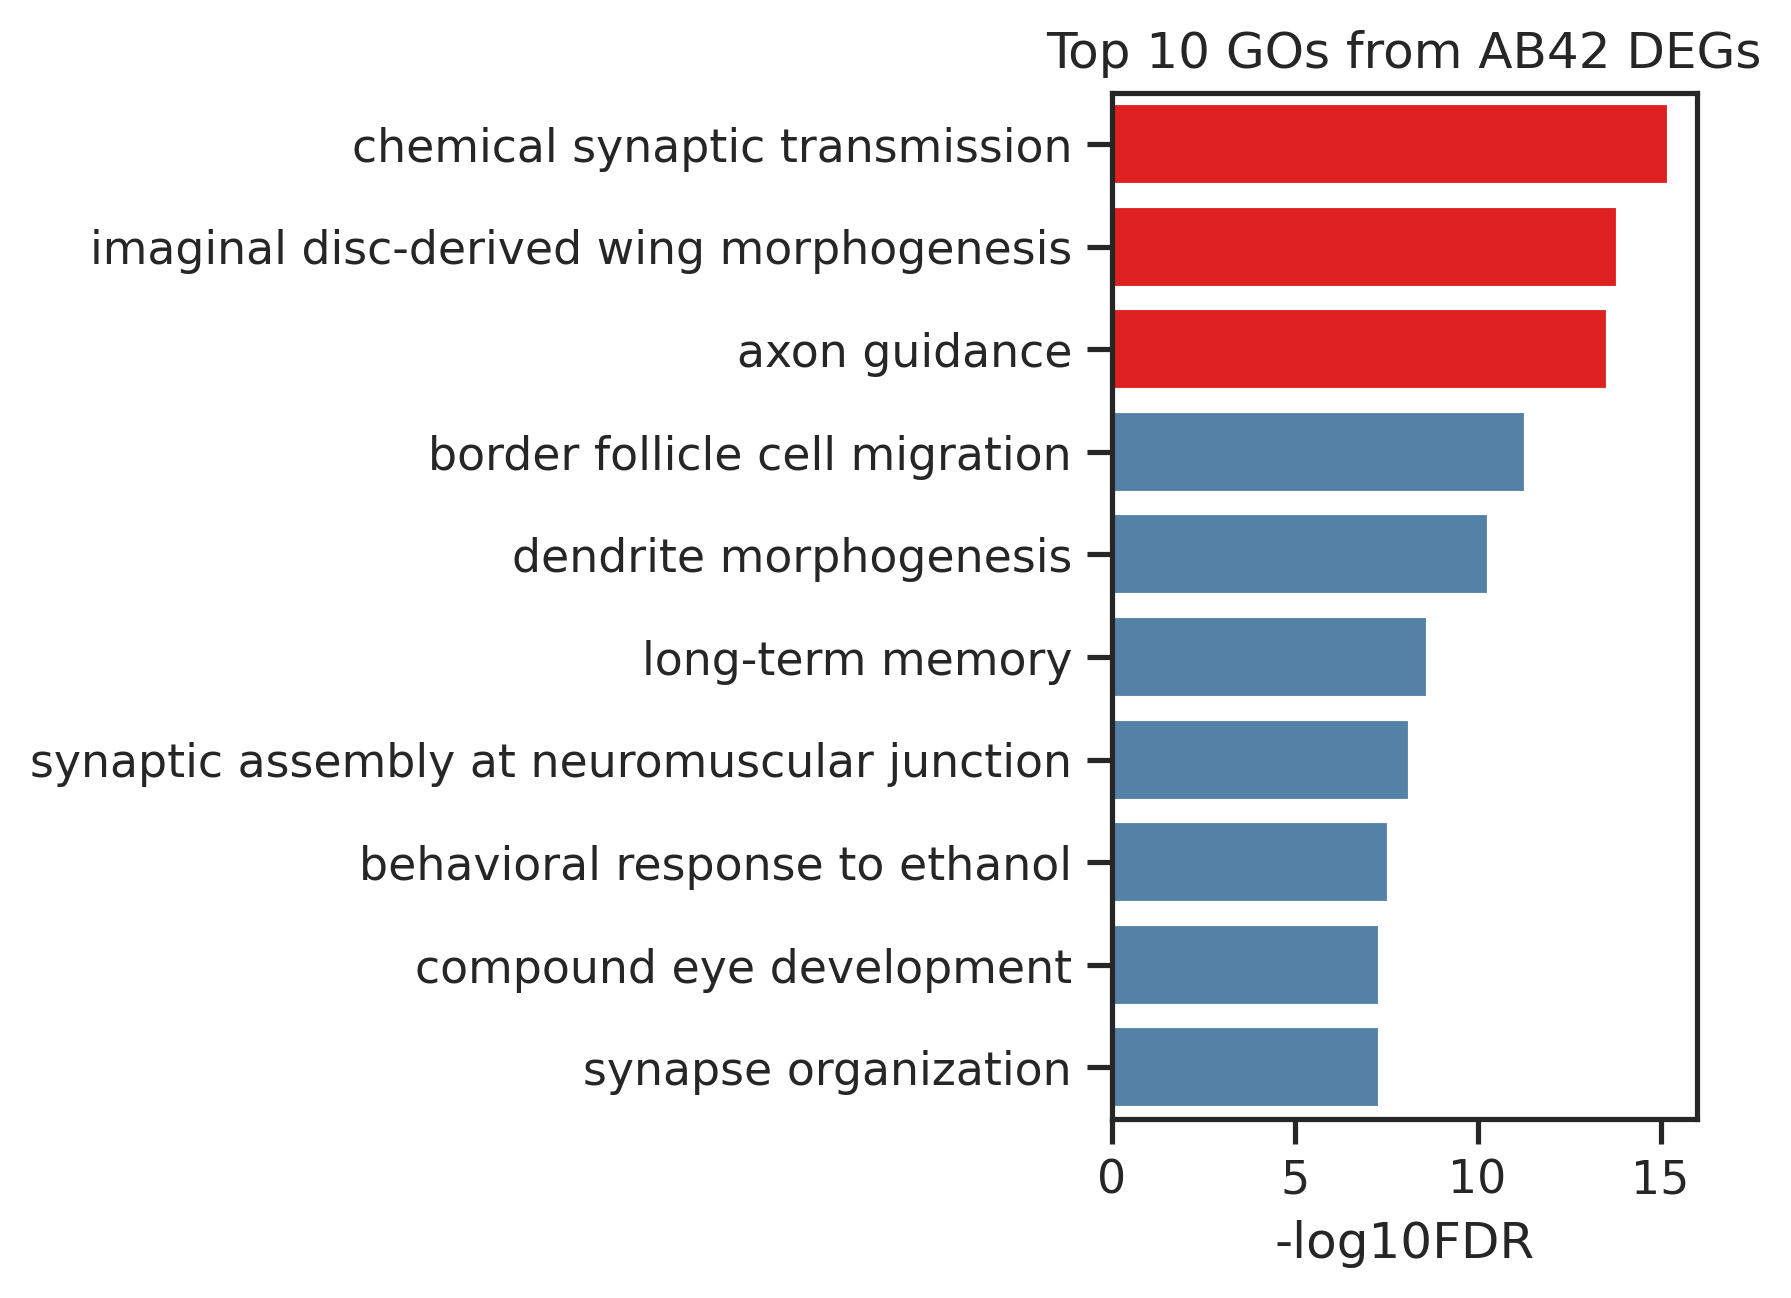

In [67]:
fig, ax = plt.subplots(figsize=(2.5, 4.5))
sns.barplot(data=ab42GO_Df_top10, x = '-log10FDR', y = 'name', ax=ax, width=0.8, color='steelblue', 
            palette=['red' if name in overlapGO_L else 'steelblue' for name in ab42GO_Df_top10.name])
plt.ylabel('')
plt.title('Top 10 GOs from AB42 DEGs')
plt.savefig(f'{figure3PicFolder}/barplot_GO_ab42GO_Df_top10.pdf', bbox_inches='tight')

plt.show()

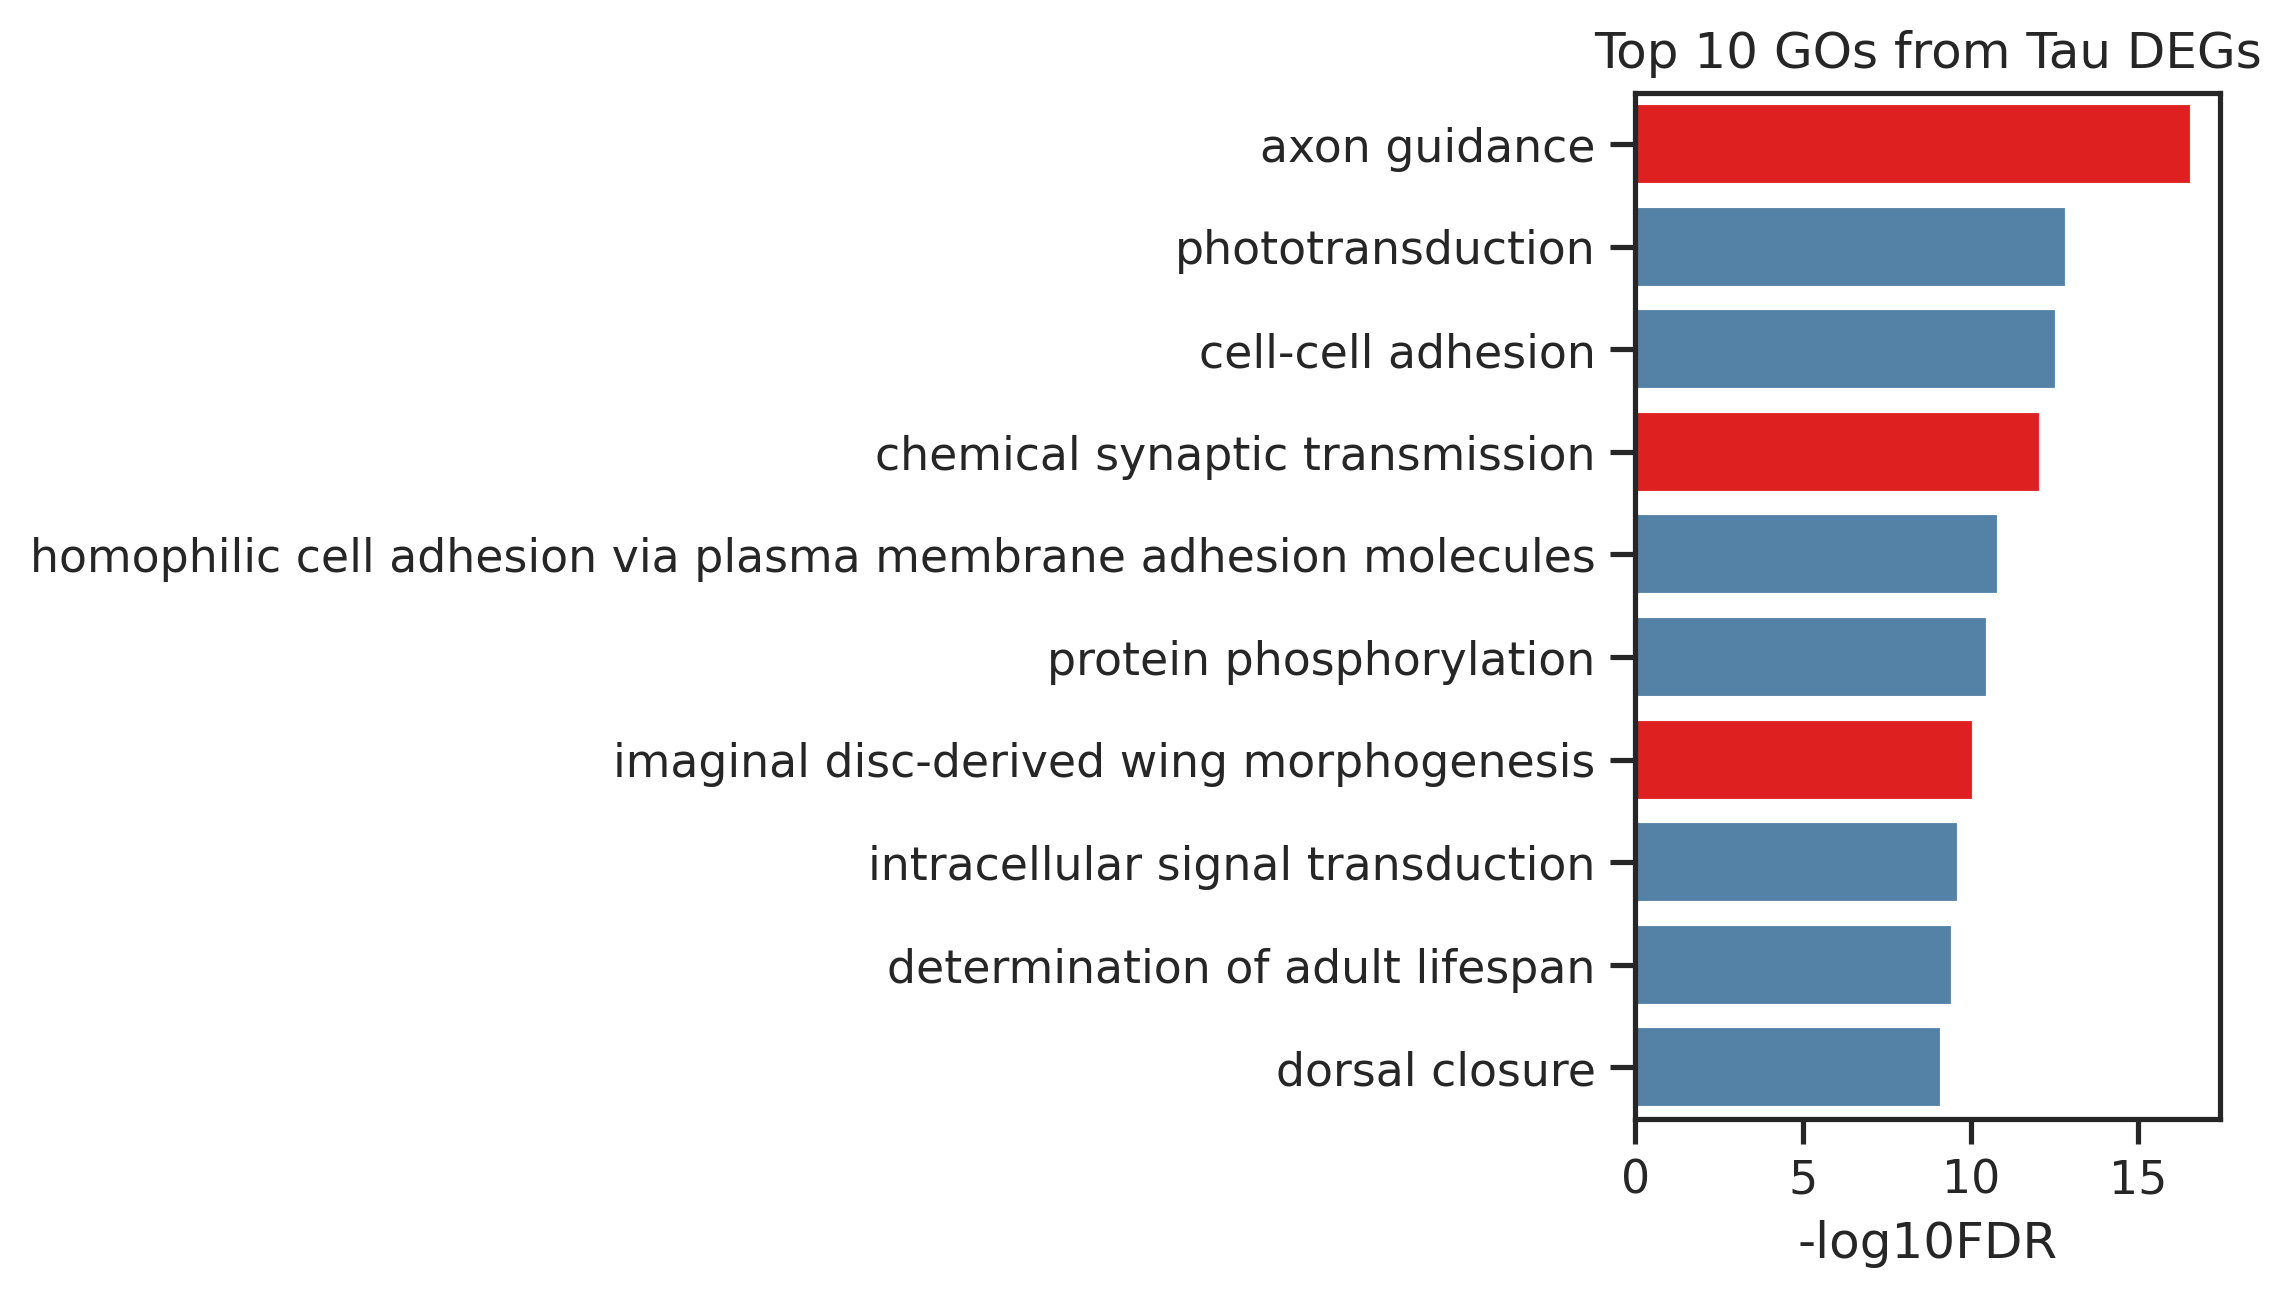

In [68]:
fig, ax = plt.subplots(figsize=(2.5, 4.5))
sns.barplot(data=tauGO_Df_top10, x = '-log10FDR', y = 'name', ax=ax, width=0.8, color='steelblue', 
            palette=['red' if name in overlapGO_L else 'steelblue' for name in tauGO_Df_top10.name])
plt.ylabel('')
plt.title('Top 10 GOs from Tau DEGs')
plt.savefig(f'{figure3PicFolder}/barplot_GO_tauGO_Df_top10.pdf', bbox_inches='tight')

plt.show()

In [69]:
ab42GO_Df_top10.to_csv(f'{figure3Folder}/ab42GO_Df_top10.csv', index=False)
tauGO_Df_top10.to_csv(f'{figure3Folder}/tauGO_Df_top10.csv', index=False)

# Finish